<head>
    <style>
        .md-typeset h2 {
            margin:0;
            }
        .md-typeset h3 {
            margin:0;
            }
        .jupyter-wrapper table.dataframe tr, .jupyter-wrapper table.dataframe th, .jupyter-wrapper table.dataframe td {
            text-align:left;
            }
        .jupyter-wrapper table.dataframe {
            table-layout: auto;
            }
    </style>
</head>

# Regression Discontinuity

![dag-rd](https://mixtape.scunning.com/06-Regression_Discontinuity_files/figure-html/unnamed-chunk-3-1.png)

In the data generating process graph, Both $X$ and $U$ could affect %Y% and
there might be other unobservable factors that could affect $X$ and $U$ too.
However, the treatment _status_ $D$ is determined by the threshold of
"running variable" $X$. 

 because the assignment variable assigns treatment on the basis of a cutoff, 
 we are never able to observe units in both treatment and control for 
 the same value of $X$. Calling back to our matching chapter, this means a 
 situation such as this one does not satisfy the overlap condition 
 needed to use matching methods, and therefore the backdoor criterion 
 cannot be met.

 The __main__ assumption of this model is the expected potential outcomes 
 are continuous at the cutoff, which is reflected graphically by the absence
 of an arrow from $X \to Y$ in the second graph because of the cutoff $c_0$
 has cut it off.  

## Continuity assumption 

In [1]:
# import key packages 
if (!require("pacman")) install.packages("pacman")
library(pacman)
p_load(tidyverse, RCurl, data.table, scico, gridExtra, naniar, 
                    scales, miceadds, here, pROC, ROCR, broom, 
                    haven, stargazer,  estimatr, palmerpenguins,
                    plotly, rdrobust, rddensity, modelsummary)

Loading required package: pacman



In [2]:
sdata <- tibble(
    x = rnorm(1000, 50, 25)
) %>%
    mutate(x = if_else(x<0, 0, x)) %>%
    filter(x < 100) %>%  ## cutoff at x = 50
    mutate(
        D = if_else(x > 50, 1, 0),
        # no treatment effect
        y1 = 25 + 0 * D + 1.5 * x + rnorm(n(), 0, 20)
    )
head(sdata)

x,D,y1
<dbl>,<dbl>,<dbl>
90.25261,1,170.80833
18.17357,0,66.65926
28.54932,0,60.23511
15.13217,0,35.76494
40.80270,0,94.37815
87.86707,1,132.32313


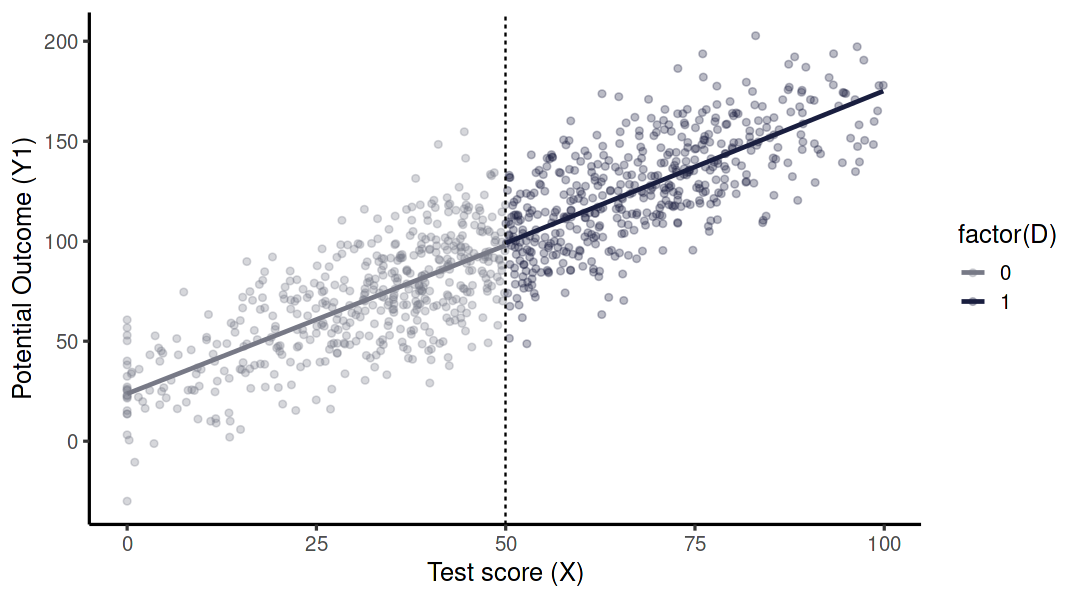

In [3]:
options(repr.plot.width=9, repr.plot.height=5)  # figsize
sdata %>%
    ggplot(aes(x, y1, color=factor(D))) +
    geom_point(alpha=0.3) +
    geom_vline(xintercept=50, color='black', linetype=2) + 
    stat_smooth(method = "lm", se = F, formula='y ~ x') +
    labs(x = "Test score (X)", y = "Potential Outcome (Y1)") +
    theme_classic(base_size=15) +
    scale_color_manual(values=c('#777986', '#191e3f'))

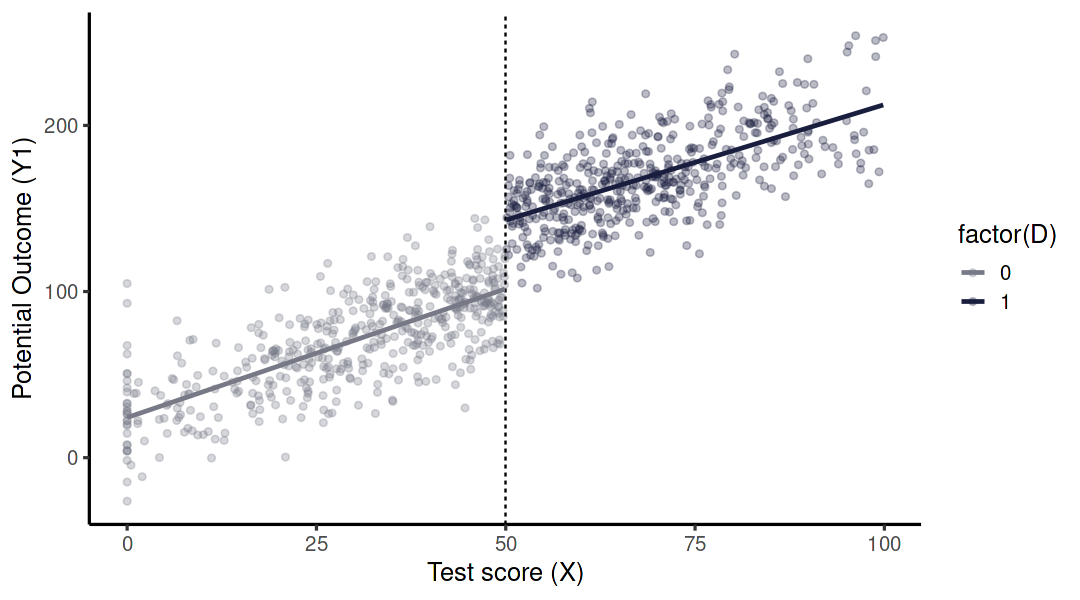

In [12]:
sdata %>%
    mutate(y2 = 25 + 40 * D + 1.5 * x + rnorm(n(), 0, 20)) %>%
    ggplot(aes(x, y2, color=factor(D))) +
    geom_point(alpha=0.3) +
    geom_vline(xintercept=50, color='black', linetype=2) + 
    stat_smooth(method = "lm", se = F, formula='y ~ x') +
    labs(x = "Test score (X)", y = "Potential Outcome (Y1)") +
    theme_classic(base_size=15) +
    scale_color_manual(values=c('#777986', '#191e3f'))

## Estimation using local and global least squares regressions

When you estimate the treatment effect with RDD model, you need to be
careful when the data generation process is not linear. 

In [31]:
sdata2 <- tibble(
    x=rnorm(1000, 100, 50)
) %>%
mutate(
    x=case_when(x < 0 ~ 0, TRUE ~ x),
    D=case_when(x > 140 ~ 1, TRUE ~ 0),
    x2 = x*x,
    x3 = x*x*x,
    # no treatment effect
    y3 = 10 + 0*D - 100*x + x2 + rnorm(1000, 0, 1000)
) %>%
filter(x < 280)
head(sdata2)

x,D,x2,x3,y3
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
115.00384,0,13225.882,1521027.2,882.0983
132.18030,0,17471.631,2309405.3,4503.6222
76.24105,0,5812.698,443166.2,-1666.0524
178.17181,1,31745.194,5656098.6,15886.5354
147.01710,1,21614.029,3177631.9,5599.1619
109.56466,0,12004.415,1315259.7,830.2699


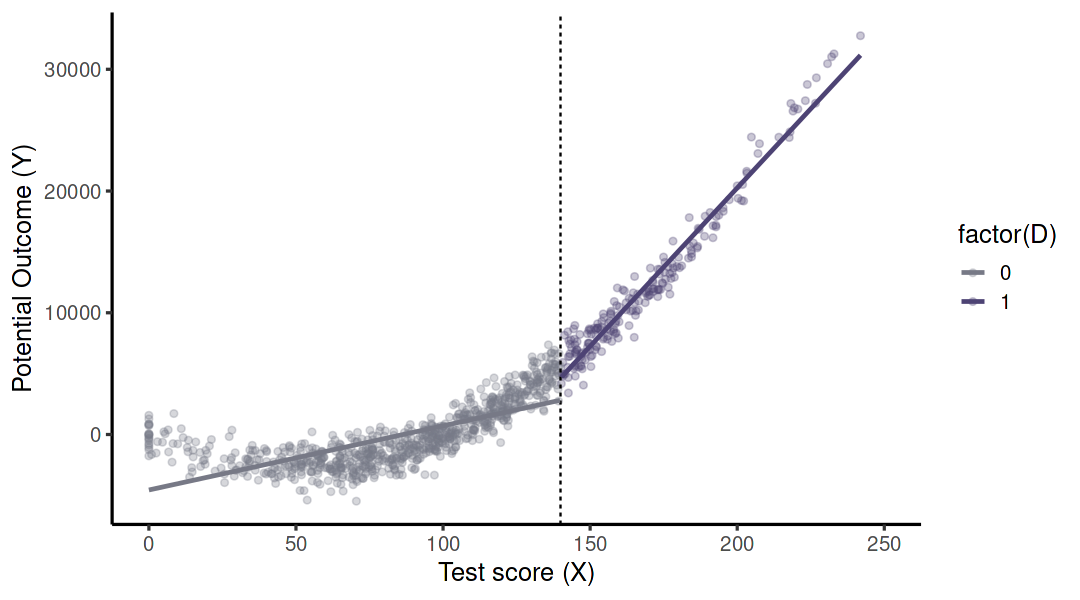

In [32]:
sdata2 %>%
    ggplot(aes(x, y3, color=factor(D))) + 
    geom_point(alpha = 0.3, na.rm=T) +
    geom_vline(xintercept = 140, colour = "black", linetype = 2) +
    stat_smooth(
        method = "lm", se = F, formula='y ~ x', na.rm=T
        ) +
    labs(x = "Test score (X)", y = "Potential Outcome (Y)") +  
    scale_color_manual(values=c('#777986', '#4d4374')) +
    scale_x_continuous(limits=c(0, 250)) +
    theme_classic(base_size=15)

In [33]:
rdd1 <- lm(y3 ~ D + x, data=sdata2)
stargazer(rdd1, type='text',
            no.space=TRUE,
            omit.stat=c('ser', 'f'))


                 Dependent variable:    
             ---------------------------
                         y3             
----------------------------------------
D                   6,003.922***        
                      (295.498)         
x                     73.500***         
                       (2.534)          
Constant            -6,328.887***       
                      (235.646)         
----------------------------------------
Observations            1,000           
R2                      0.811           
Adjusted R2             0.810           
Note:        *p<0.1; **p<0.05; ***p<0.01


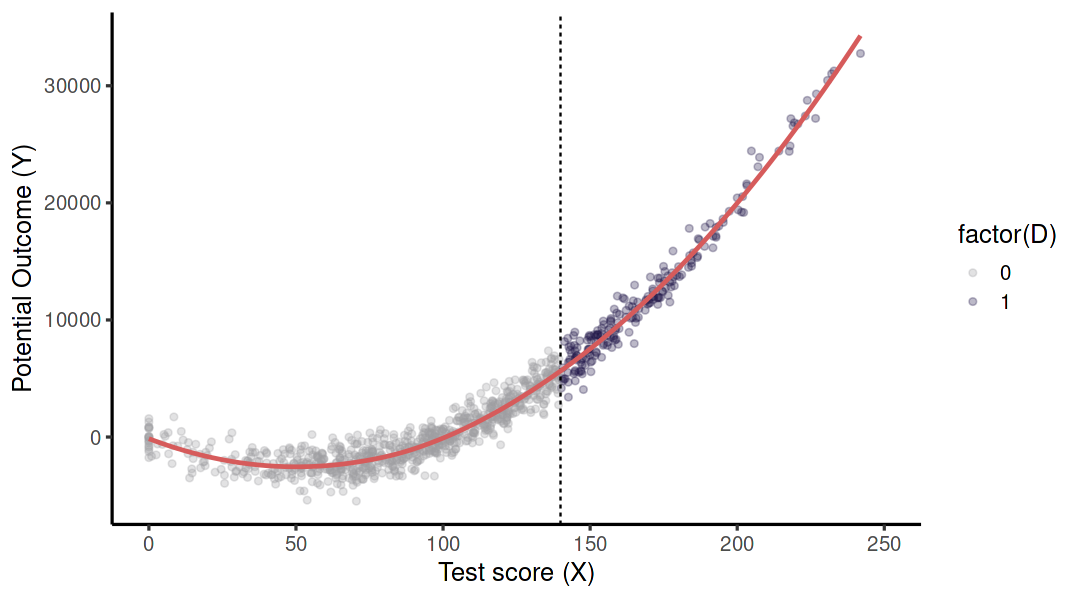

In [45]:
sdata2 %>%
    ggplot(aes(x, y3, color=factor(D))) + 
    geom_point(alpha = 0.3, na.rm=T) +
    geom_vline(xintercept = 140, colour = "black", linetype = 2) +
    stat_smooth(
        method = "loess", se = F, formula='y ~ x', na.rm=T,
        color='#d65b5b'
        ) +
    labs(x = "Test score (X)", y = "Potential Outcome (Y)") +  
    scale_color_manual(values=c('#9e9ea1', '#201549')) +
    scale_x_continuous(limits=c(0, 250)) +
    theme_classic(base_size=15)

In [47]:
rdd2 <- lm(y3 ~ D + x +x2, data=sdata2)
stargazer(rdd2, type='text',
            no.space=TRUE,
            omit.stat=c('ser', 'f'))


                 Dependent variable:    
             ---------------------------
                         y3             
----------------------------------------
D                      -19.794          
                      (138.133)         
x                    -99.199***         
                       (2.468)          
x2                    0.999***          
                       (0.013)          
Constant              -103.778          
                      (121.817)         
----------------------------------------
Observations            1,000           
R2                      0.972           
Adjusted R2             0.972           
Note:        *p<0.1; **p<0.05; ***p<0.01


## Nonparametric kernels

![kernelbias](https://mixtape.scunning.com/graphics/kernel1.png)

## Challenges to identification

The requirement for RDD to estimate a causal effect are the continuity assumptions. That is, the expected potential outcomes change smoothly as a function of the running variable through the cutoff. In words, this means that the only thing that causes the outcome to change abruptly at $c_0$ is the treatment. But, this can be violated in practice if any of the following is true:

1. The assignment rule is known in advance.
2. Agents are interested in adjusting.
3. Agents have time to adjust.
4. The cutoff is endogenous to factors that independently cause potential outcomes to shift.
5. There is nonrandom heaping along the running variable.

## A hypothetical example

In this hypothetical example, students take an entrance exam at the beginning of a school year. Those who score 70 or below are automatically enrolled in a free tutoring program and receive assistance throughout the year. At the end of the school year, students take a final test, or exit exam (with a maximum of 100 points) to measure how much they learned overall. Remember, this is a hypothetical example and tests like this don’t really exist, but just go with it. 

To apply regression discontuinity we have to:

1. determine if process of assigning treatment is rule-based
2. determine if the design is fuzzy or sharp
3. check for discontinuity in running variable around cutpoint
4. check for discontinuity in outcome across running variable 
5. measure the size of the effect 


In [4]:
tutoring <- read_csv('./data/tutoring_program.csv')

Rows: 1000 Columns: 4
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (3): id, entrance_exam, exit_exam
lgl (1): tutoring

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [53]:
head(tutoring)

id,entrance_exam,exit_exam,tutoring
<dbl>,<dbl>,<dbl>,<lgl>
1,92.4,78.1,FALSE
2,72.8,58.2,FALSE
3,53.7,62.0,TRUE
4,98.3,67.5,FALSE
5,69.7,54.1,TRUE
6,68.1,60.1,TRUE


In [13]:
gray_scale <- c('#F3F4F8','#D2D4DA', '#B3B5BD', 
                '#9496A1', '#7d7f89', '#777986', 
                '#656673', '#5B5D6B', '#4d505e',
                '#404352', '#2b2d3b', '#282A3A',
                '#1b1c2a', '#191a2b',
                '#141626', '#101223')

### Check assumptions 

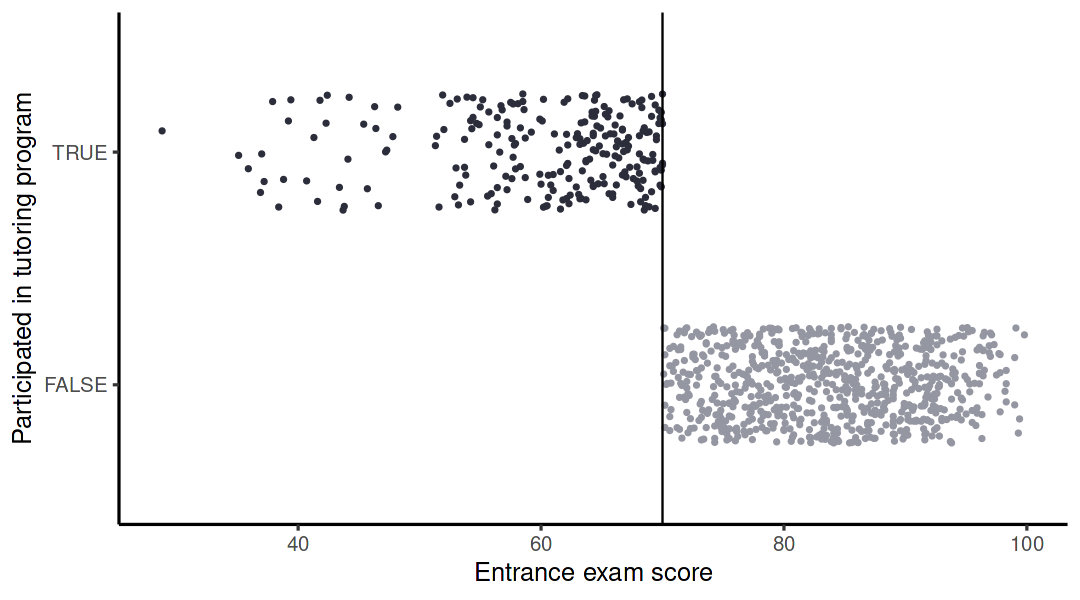

In [79]:
# Step 1 has to te checked with institutional logic
# step 2 determine if the design if fuzzy or shapr 
tutoring %>%
    ggplot(aes(x=entrance_exam, y=tutoring, color=tutoring)) +
    geom_point(
        size=1,
        # add jitter data
        position=position_jitter(width=0, height=0.25, seed=1234)
    ) + 
    geom_vline(xintercept=70) +
    labs(x = "Entrance exam score", y = "Participated in tutoring program") +
    theme_classic(base_size=15) +
    theme(
        legend.position='none'
    ) +
    scale_color_manual(values=c(gray_scale[4], gray_scale[11]))

In [80]:
tutoring %>% 
  group_by(tutoring, entrance_exam <= 70) %>% 
  summarize(count = n())

`summarise()` has grouped output by 'tutoring'. You can override using the
`.groups` argument.


tutoring,entrance_exam <= 70,count
<lgl>,<lgl>,<int>
FALSE,FALSE,759
TRUE,TRUE,241


Next we need to see if there was any manipulation in the running variable—maybe lots of people bunched up around 70 because of how the test was graded (i.e. students wanted to get into the program, so they purposely did poorly on the exam to get under 70). We can do this a couple different ways. First, we’ll make a histogram of the running variable (test scores) and see if there are any big jumps around the threshold:

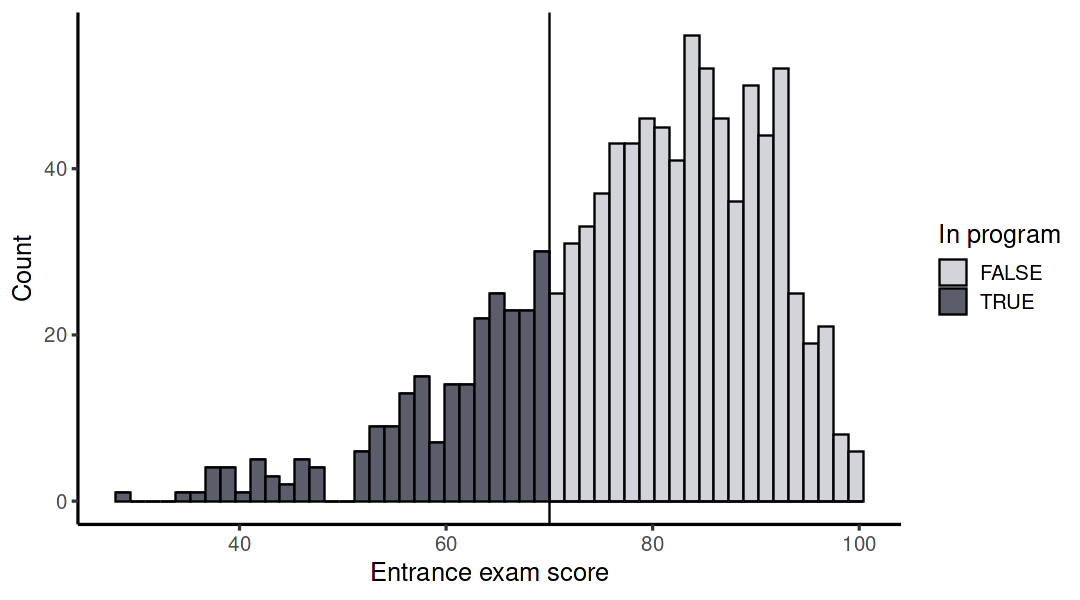

In [94]:
# check for discontinuity in running variable
tutoring %>%
    ggplot(aes(x=entrance_exam, fill=tutoring)) +
    geom_histogram(bins=50, color='black', boundary=70) +
    geom_vline(xintercept=70) + 
    labs(x = "Entrance exam score", y = "Count", fill = "In program") + 
    theme_classic(base_size=15) + 
    scale_fill_manual(values=c(gray_scale[2], gray_scale[8]))

Here it doesn’t look like there’s a jump around the cutoff—there’s a tiny visible difference between the height of the bars right before and right after the 70-point threshold, but it seems to follow the general shape of the overall distribution. We can check to see if that jump is statistically significant with a McCrary density test. 

In [95]:
# McCrary's denstiy test 
mctest <- rddensity(tutoring$entrance_exam, c=70)
summary(mctest)


Manipulation testing using local polynomial density estimation.

Number of obs =       1000
Model =               unrestricted
Kernel =              triangular
BW method =           estimated
VCE method =          jackknife

c = 70                Left of c           Right of c          
Number of obs         237                 763                 
Eff. Number of obs    208                 577                 
Order est. (p)        2                   2                   
Order bias (q)        3                   3                   
BW est. (h)           22.444              19.966              

Method                T                   P > |T|             
Robust                -0.5521             0.5809              



Warning message in summary.CJMrddensity(mctest):
“There are repeated observations. Point estimates and standard errors have been adjusted. Use option massPoints=FALSE to suppress this feature.”



P-values of binomial tests (H0: p=0.5).

Window Length / 2          <c     >=c    P>|T|
0.300                       9      11    0.8238
0.600                      15      16    1.0000
0.900                      17      19    0.8679
1.200                      22      22    1.0000
1.500                      26      29    0.7877
1.800                      34      35    1.0000
2.100                      41      44    0.8284
2.400                      43      51    0.4705
2.700                      46      56    0.3729
3.000                      51      61    0.3952


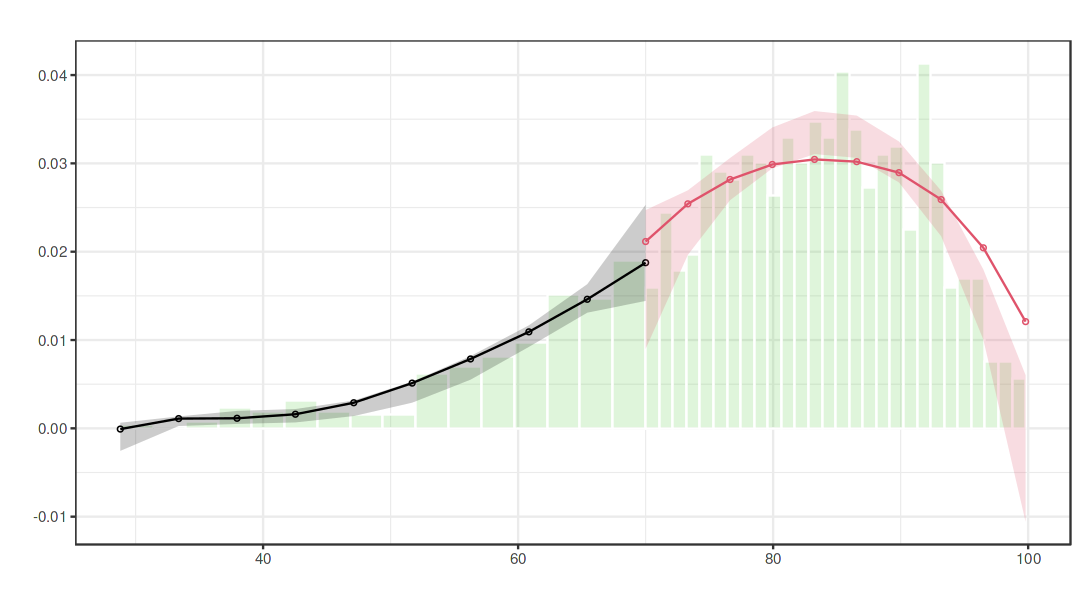

In [97]:
mc_density_plot <- rdplotdensity(
        rdd=mctest, 
        X=tutoring$entrance_exam,
        type='both')

Now that we know this is a sharp design and that there’s no bunching of test scores around the 70-point threshold, we can finally see if there’s a discontinuity in final scores based on participation in the tutoring program. Plot the running variable on the x-axis, the outcome variable on the y-axis, and color the points by whether they participated in the program.

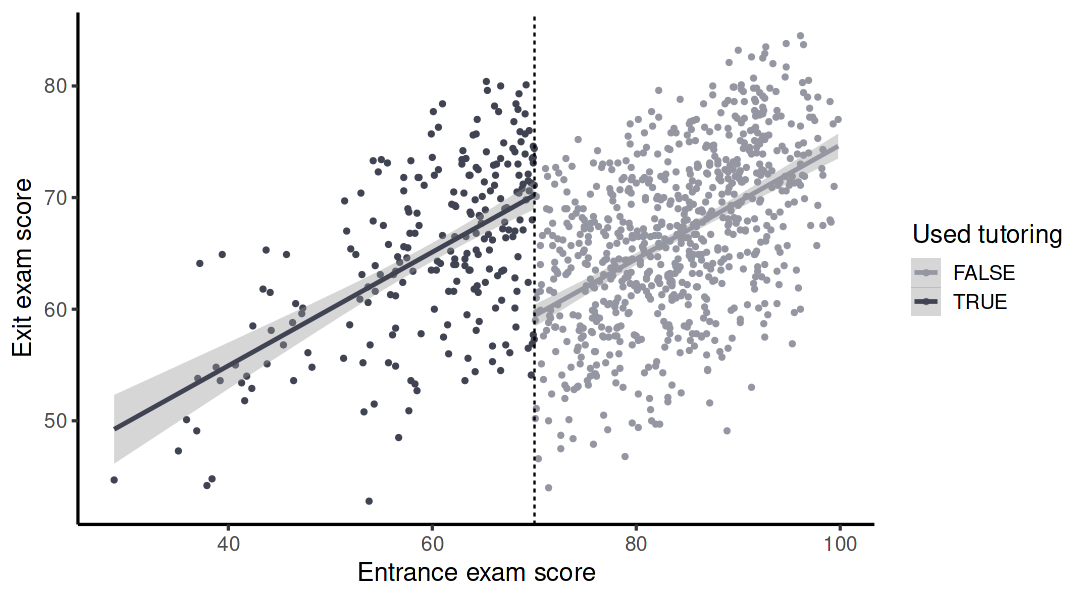

In [16]:
tutoring %>%
    ggplot(aes(x=entrance_exam, y=exit_exam, color=tutoring)) + 
    geom_point(size=1) + 
    geom_smooth(method='lm', formula='y ~ x') + 
    geom_vline(xintercept=70, linetype=2) +
    labs(x="Entrance exam score", y="Exit exam score",
                color="Used tutoring") +
    theme_classic(base_size=15) +
    scale_color_manual(values=c(gray_scale[4], gray_scale[10]))


### Measure the size of the effect

In [17]:
tutoring_centered <- tutoring %>%
    mutate(entrance_centered = entrance_exam - 70)

simple_model <- lm(exit_exam ~ entrance_centered + tutoring,
                        data=tutoring_centered)
stargazer(simple_model, type='text',
            no.space=TRUE,
            omit.stat=c('ser', 'f'))


                      Dependent variable:    
                  ---------------------------
                           exit_exam         
---------------------------------------------
entrance_centered          0.510***          
                            (0.027)          
tutoring                   10.800***         
                            (0.800)          
Constant                   59.411***         
                            (0.442)          
---------------------------------------------
Observations                 1,000           
R2                           0.268           
Adjusted R2                  0.267           
Note:             *p<0.1; **p<0.05; ***p<0.01


In [18]:
# fit the model within a smaller windown
bw_10_model <- lm(
    exit_exam ~ entrance_centered + tutoring,
    data = filter(tutoring_centered, entrance_centered >= -10 &
                        entrance_centered <= 10)
)
stargazer(bw_10_model, type='text',
            no.space=TRUE,
            omit.stat=c('ser', 'f'))


                      Dependent variable:    
                  ---------------------------
                           exit_exam         
---------------------------------------------
entrance_centered          0.388***          
                            (0.114)          
tutoring                   9.273***          
                            (1.309)          
Constant                   60.377***         
                            (0.752)          
---------------------------------------------
Observations                  404            
R2                           0.162           
Adjusted R2                  0.158           
Note:             *p<0.1; **p<0.05; ***p<0.01


In [24]:
bw_5_model <- lm(
    exit_exam ~ entrance_centered + tutoring,
    data = filter(tutoring_centered, entrance_centered >= -5 &
                        entrance_centered <= 5)
)
modelsummary(
    list('Full data' = simple_model, 'Bandwidth=10' = bw_10_model,
                            'Bandwidth=5' = bw_5_model),
     output = "markdown"
)



|                  | Full data | Bandwidth=10 | Bandwidth=5 |
|:-----------------|:---------:|:------------:|:-----------:|
|(Intercept)       |  59.411   |    60.377    |   60.631    |
|                  |  (0.442)  |   (0.752)    |   (1.117)   |
|entrance_centered |   0.510   |    0.388     |    0.380    |
|                  |  (0.027)  |   (0.114)    |   (0.331)   |
|tutoringTRUE      |  10.800   |    9.273     |    9.122    |
|                  |  (0.800)  |   (1.309)    |   (1.912)   |
|Num.Obs.          |   1000    |     404      |     194     |
|R2                |   0.268   |    0.162     |    0.222    |
|R2 Adj.           |   0.267   |    0.158     |    0.214    |
|AIC               |  6595.3   |    2663.5    |   1303.1    |
|BIC               |  6615.0   |    2679.5    |   1316.2    |
|Log.Lik.          | -3293.663 |  -1327.755   |  -647.567   |
|F                 |  182.971  |    38.891    |   27.310    |
|RMSE              |   6.52    |     6.47     |    6.81     |

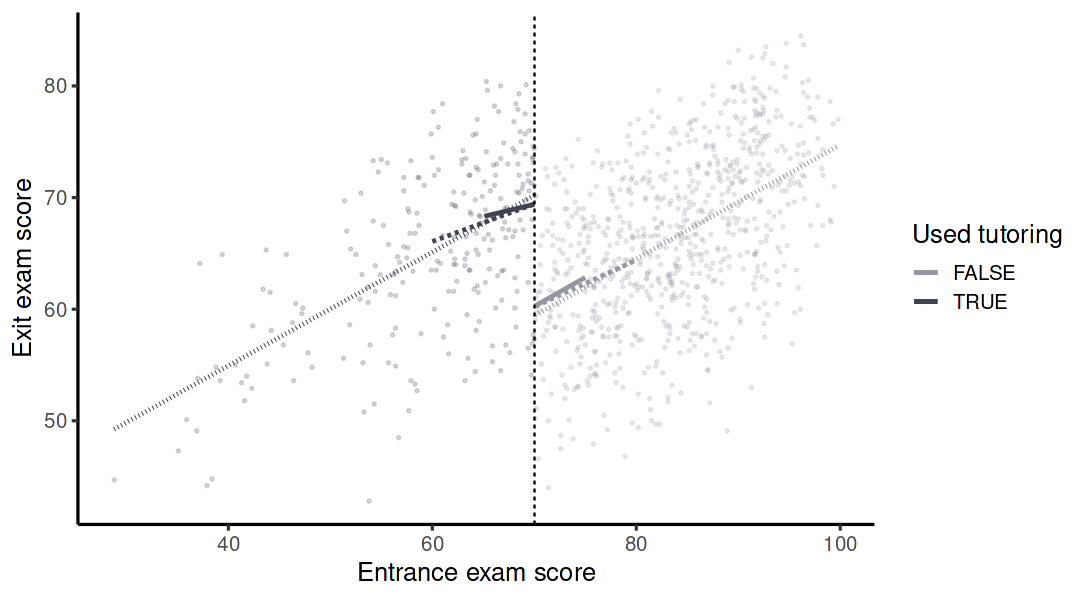

In [37]:
# effect of bandwidth
ggplot(tutoring, aes(x=entrance_exam, y=exit_exam, color=tutoring)) +
    geom_point(size=0.5, alpha=0.2) +
    geom_smooth(
        method='lm', se=F, linetype='dotted', 
        formula='y~x', size=1
        ) +
    # Add lines for bandwidth = 10
    geom_smooth(data = filter(
        tutoring, entrance_exam <= 70, entrance_exam >= 60
        ), 
        method = "lm", se = FALSE, formula='y~x',
        linetype = "dashed", size = 1) +
    geom_smooth(data = filter(
    tutoring, entrance_exam > 70, entrance_exam <= 80
    ), 
    method = "lm", se = FALSE, formula='y~x', 
    linetype = "dashed", size = 1) +
    # Add lines for bandwidth = 5
    geom_smooth(data = filter(
        tutoring, entrance_exam <= 70, entrance_exam >= 65
        ), 
        method = "lm", se = FALSE, formula='y~x',
        size = 1) +
    geom_smooth(data = filter(
    tutoring, entrance_exam > 70, entrance_exam <= 75
    ), 
    method = "lm", se = FALSE, formula='y~x', 
    size = 1) + 
    geom_vline(xintercept=70, linetype=2) +
    labs(x="Entrance exam score", y="Exit exam score",
                color="Used tutoring") +
    theme_classic(base_size=15) +
    scale_color_manual(values=c(gray_scale[4], gray_scale[10]))

### Nonparametric estimation

In [43]:
rdrobust(y=tutoring$exit_exam, x=tutoring$entrance_exam, c=70) %>%
    summary()

Warning message in rdrobust(y = tutoring$exit_exam, x = tutoring$entrance_exam, :
“Mass points detected in the running variable.”


Sharp RD estimates using local polynomial regression.

Number of Obs.                 1000
BW type                       mserd
Kernel                   Triangular
VCE method                       NN

Number of Obs.                  237          763
Eff. Number of Obs.             144          256
Order est. (p)                    1            1
Order bias  (q)                   2            2
BW est. (h)                   9.969        9.969
BW bias (b)                  14.661       14.661
rho (h/b)                     0.680        0.680
Unique Obs.                     155          262

        Method     Coef. Std. Err.         z     P>|z|      [ 95% C.I. ]       
  Conventional    -8.578     1.601    -5.359     0.000   [-11.715 , -5.441]    
        Robust         -         -    -4.352     0.000   [-12.101 , -4.587]    


[1] "Mass points detected in the running variable."


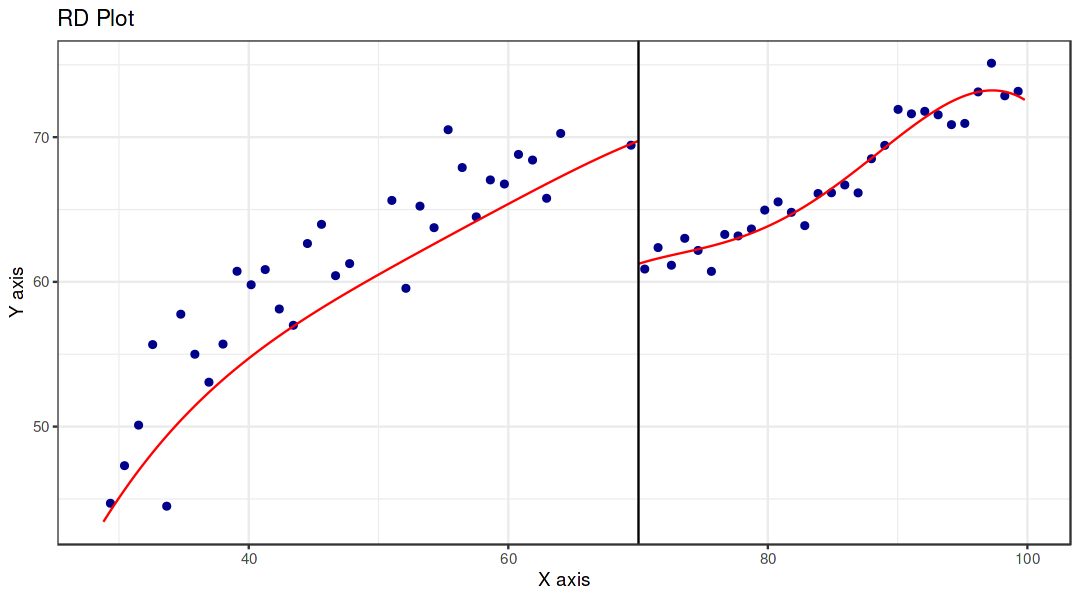

In [39]:
rdplot(y = tutoring$exit_exam, x = tutoring$entrance_exam, c = 70)